Preprocessing 

2025-07-06 12:25:08.907226: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-06 12:25:08.946734: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-06 12:25:09.173164: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-06 12:25:09.346842: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751804709.520251    9283 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751804709.57

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


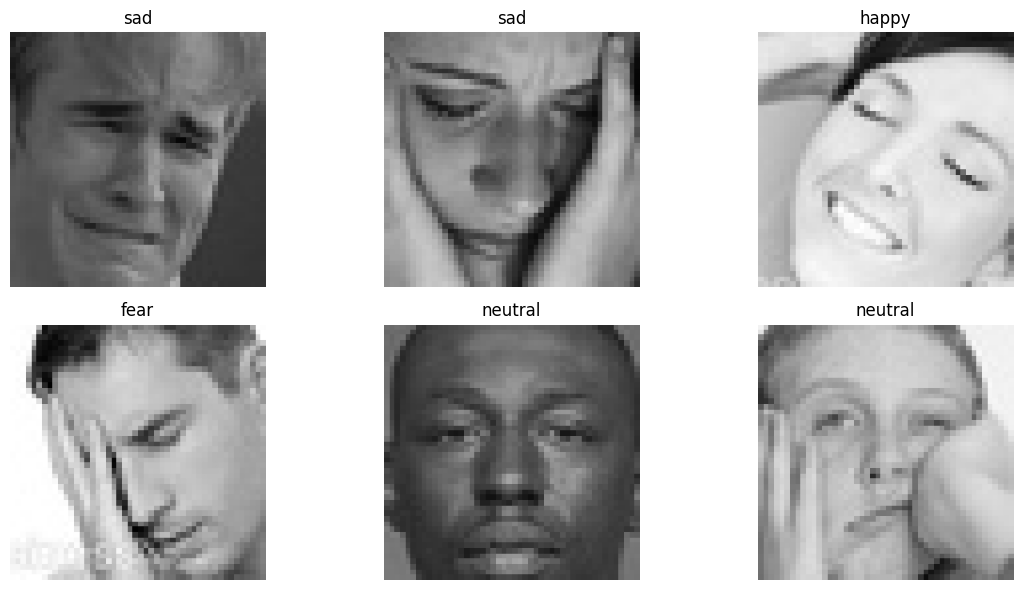

In [5]:
# 1. Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 2. Define Paths
train_dir = '/workspaces/Emotion_detector/Data/images/images/train'         # Adjust path if needed
val_dir = '/workspaces/Emotion_detector/Data/images/images/validation'

# 3. Image Settings for ResNet
img_size = (224, 224)                 # ResNet input size
batch_size = 32

# 4. Data Generators (Normalize RGB)
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# 5. Load Training Data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='rgb',                 # ResNet needs RGB
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# 6. Load Validation Data
val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# 7. Check Class Indices
print("Class labels:", train_data.class_indices)

# 8. Visualize Sample Images
images, labels = next(train_data)
class_names = list(train_data.class_indices.keys())

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.title(f"{class_names[np.argmax(labels[i])]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
